<a href="https://colab.research.google.com/github/ddamddi/2020_cau_oss_hackathon/blob/master/hackathon_team15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0. 해커톤 진행 주의사항**

**1)  개발 관련 주의사항**
*   [1. 초기 환경 설정]은 절대 수정하지 말 것
*   모든 구현은 [2. 데이터 전처리] 및 [3.모델 생성]에서만 진행
*   [4. 모델 저장]에서 team_name 변수 변경 (예.`team_name = 'team01'`)
 *    트레이닝 중간에 checkpoint를 활용하여 모델을 저장한 경우에도 파일 이름 양식 통일 필수
*   Colab 사용중 실수로 데이터 손실이 발생할 수도 있으니 중간 결과값을 github에 업로드 
 *    "런타임->모든 런타임 재설정"은 절대 누르지 말 것 (저장한 모델 데이터가 모두 삭제됨)
*   효율적인 구현 및 테스팅을 위해 GPU 가속 기능 활성화
 *    "런타임 -> 런타임 유형변경 -> 하드웨어 가속기 -> GPU 설정"
*   주석을 최대한 자세히 작성
*   Keras API 관련하여 [Keras Documentation](https://keras.io/) 참조

**2) 제출 관련 주의사항**
*  제출물
 *  소스코드 (hackathon_teamXX.ipynb)
 *  컴파일된 모델 파일 (model_entire_teamXX.h5)
 *  모델 발표 자료 
* 제출 기한: **오후 5시 (단, 발표자료는 11시)**
* 제출 방법: [GitHub README](https://github.com/cauosshackathonta/2020_cau_oss_hackathon/) 참조

 
**3) 평가 관련 주의사항**
*  모델 성능 = 테스트 데이터 셋 분류 정확도
 *  model.evaluate(x_test, y_test)
*  제출된 모델들의 테스트 데이터 셋 분류 정확도를 기준으로 수상작 결정
*  수상 후보들에 대해서는 소스코드를 기반으로 모델 재검증 
 
**4) 수상 실격 사유**
*  유사한 소스코드 or 알고리즘이 적발될 경우
*  소스코드와 제출된 모델이 상이한 경우
*  개발 관련 주의사항을 지키지 않은 경우
 *  예: [초기 환경 설정]을 수정한 경우
*  데이터 셋을 변조한 경우
 *  예. 테스트 데이터 셋을 트레이닝 데이터 셋에 포함하여 모델 생성 
*  주석이 소스코드와 맞지 않거나 미비할 경우






# **1. 초기 환경 설정**



In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

# tensorflow와 tf.keras 및 관련 라이브러리 임포트
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

import numpy as np

# 데이터셋 다운로드
check = !if [ -d 'dataset/' ]; then echo "1" ; else echo "0"; fi
if (check[0] is '0' ):
  !mkdir dataset
  !wget 'https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip'
  !unzip matlab.zip -d /content/dataset

# 데이터셋 로드
from scipy import io as spio
emnist = spio.loadmat("/content/dataset/matlab/emnist-balanced.mat")

x_train = emnist["dataset"][0][0][0][0][0][0]
y_train = emnist["dataset"][0][0][0][0][0][1]

x_test = emnist["dataset"][0][0][1][0][0][0]
y_test = emnist["dataset"][0][0][1][0][0][1]

# # 분류를 위해 클래스 벡터를 바이너리 매트릭스로 변환
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# 데이터 28x28 이미지화
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# 총 클래스 개수
num_classes = y_test.shape[1]
input_shape = x_test.shape[1:]

# **2. 데이터 전처리**



In [2]:
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from tqdm.notebook import tqdm

In [3]:
def smooth_labels(labels, factor=0.1):
  for idx in tqdm(range(len(labels))):
    labels[idx] *= (1-factor)
    labels[idx] += (factor / labels[idx].shape[0])
  return labels

In [4]:
CONFIG = {
    'team_name': 'team15',
    'filepath': '/content/',
    'augmentations': {
      'label_smoothing' : True,
      'label_smoothing_factor': 0.2,

      'cutout' : True,
    },

    'epoch': 50,
    'batch_size': 128
}

In [5]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(112800, 28, 28, 1)
(112800, 47)
(18800, 28, 28, 1)
(18800, 47)


In [6]:
X_MEAN = 44.651615
X_STD  = 84.974724

def mean_std_normalization(x):
  x -= X_MEAN
  x /= X_STD
  return x

In [7]:
def random_erasing(input_img, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
  prob = np.random.rand()

  if prob > p:
    return input_img
  
  img_h = img_w = 28
  while True:
    s = np.random.uniform(s_l, s_h) * img_h * img_w
    r = np.random.uniform(r_1, r_2)
    w = int(np.sqrt(s / r))
    h = int(np.sqrt(s * r))
    left = np.random.randint(0, img_w)
    top = np.random.randint(0, img_h)

    if left + w <= img_w and top + h <= img_h:
        break

  c = np.random.uniform(v_l, v_h)

  input_img[top:top+h, left:left+w] = c

  return input_img

In [8]:
if CONFIG['augmentations']['label_smoothing']:
  y_train = smooth_labels(y_train, factor=CONFIG['augmentations']['label_smoothing_factor'])

In [9]:
def preprocessing_input(x):
  x = random_erasing(x)
  x = mean_std_normalization(x)
  return x

In [10]:
if CONFIG['augmentations']['cutout']:
  preprocessing_func = preprocessing_input
  print('using mean_std_normalization + cutout')
else:
  preprocessing_func = mean_std_normalization
  print('using mean_std_normalization')

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_func,
    # horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    # brightness_range=[0.2,1.0],
    # rotation_range=30,
)

train_generator = train_datagen.flow(
    x=x_train,
    y=y_train,
    shuffle=True,
    batch_size=CONFIG['batch_size'],
)

using mean_std_normalization + cutout


In [24]:
test_datagen = ImageDataGenerator(preprocessing_function=mean_std_normalization)
test_generator = test_datagen.flow(x=x_test, y=y_test, batch_size=CONFIG['batch_size'],)

# **3. 모델 생성**

In [12]:
from keras.models import Sequential
from keras.layers import MaxPooling2D, Flatten, Dense, Conv2D, BatchNormalization, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam
import math
from keras.callbacks import Callback
from keras import backend as K

In [13]:
class ConsineAnnealingScheduler(Callback):
  def __init__(self, T_max, eta_max, eta_min=0, verbose=1):
    super(ConsineAnnealingScheduler, self).__init__()
    self.T_max = T_max
    self.eta_max = eta_max
    self.eta_min = eta_min
    self.verbose = verbose
  
  def on_epoch_begin(self, epoch, logs=None):
    lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / (self.T_max - 1))) / 2
    if self.verbose > 0:
      print('\nEpoch %05d: CosineAnnealingScheduler setting learning rate %s to %s.' % (epoch + 1, self.model.optimizer.lr, lr))
    K.set_value(self.model.optimizer.lr, lr)

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    logs['lr'] = K.get_value(self.model.optimizer.lr)

In [14]:
def callbacks():
  callbacks = [
            # ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='auto'),
            ConsineAnnealingScheduler(T_max=CONFIG['epoch'], eta_max=1e-3, eta_min=1e-6),
            ModelCheckpoint(
                filepath='/content/checkpoint_entire_best.h5',
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=True,
                mode="auto",
                save_freq="epoch"
            )]

  return callbacks

In [15]:
def optimizer() -> keras.optimizers.Optimizer:
  return Adam(lr=1e-3)

In [16]:
# 순차 모델 생성 (가장 기본구조)
model = Sequential()

# 28x28x1 -> 
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same', input_shape=input_shape))
model.add(LeakyReLU())
model.add(Conv2D(32, kernel_size=3, strides=1, padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(64, kernel_size=5, strides=2, padding='same'))
model.add(LeakyReLU())
model.add(Dropout(0.3))


model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(64, kernel_size=3, strides=1, padding='same'))
model.add(LeakyReLU())
model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
model.add(LeakyReLU())
model.add(Dropout(0.3))


model.add(Conv2D(128, kernel_size=3))
model.add(LeakyReLU())
model.add(Flatten())
model.add(keras.layers.Dense(num_classes, activation=tf.nn.softmax))

# 모델 컴파일
# optimizer: 모델을 업데이트 하는 방식
# loss: 모델의 정확도를 판단하는 방식
# metrics: 트레이닝 및 테스팅 성능 모니터링을 위한 평가지표
model.compile(loss='categorical_crossentropy', optimizer=optimizer(), metrics=['accuracy'])


# 체크포인트 생성
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/checkpoint_entire_best.h5', monitor='val_accuracy', verbose=1, save_weight_only=False, save_best_only=True, mode='auto')

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0

In [18]:
# 모델 트레이닝
# batch_size: 전체 데이터셋 중 몇개씩 학습시킬 것인지
# epoch: 학습에 전체 데이터셋이 총 몇번 이용될 것인지
# shuffle: 학습전에 트레이닝 데이터셋을 랜덤하게 섞을 것인지
# validation_data: 중간 성능 검증에 사용할 data set
# model.fit(x_train_after, y_train, batch_size = 128, epochs = 5, shuffle=True, callbacks=[cp_callback], validation_data=(x_test_after, y_test))
hist = model.fit_generator(generator=train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=CONFIG['epoch'],
                    callbacks=callbacks(),
                    validation_data=test_generator,
                    use_multiprocessing=True,
                    workers=0)

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: CosineAnnealingScheduler setting learning rate <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001> to 0.001.
Epoch 1/50
882/882 [==============================] - ETA: 0s - loss: 2.1668 - accuracy: 0.6665
Epoch 00001: val_accuracy improved from -inf to 0.84053, saving model to /content/checkpoint_entire_best.h5
882/882 [==============================] - 49s 55ms/step - loss: 2.1668 - accuracy: 0.6665 - val_loss: 0.5877 - val_accuracy: 0.8405

Epoch 00002: CosineAnnealingScheduler setting learning rate <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001> to 0.0009989737236787931.
Epoch 2/50
882/882 [==============================] - ETA: 0s - loss: 1.8549 - accuracy: 0.7826
Epoch 00002: val_accuracy improved from 0.84053 to 0.86543, saving model to /content/checkpoint_entire_best.h5
882/882 [==============================] - 49s 55ms/step - loss: 1.8549 - accuracy: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  if __name__ == '__main__':


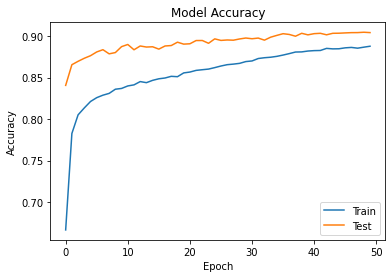

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Unrecognized location 'upper_left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


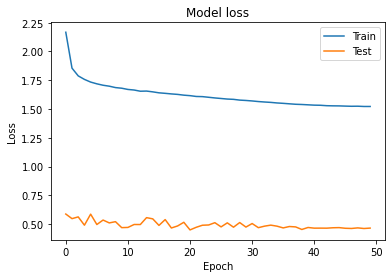

In [22]:
import matplotlib.pyplot as plt

# Accuracy Visualization
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'],loc='upper_left')
plt.show()

# Loss Visualization
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper_left')
plt.show()

# **4. 모델 저장**

In [20]:
save_path = '/content/'
team_name = CONFIG['team_name']

# Load Best Acc Model
model.load_weights(save_path + 'checkpoint_entire_best.h5')

# 트레이닝된 전체 모델을 저장합니다.
model.save(save_path +  'model_entire_'+ team_name + '.h5')

# **5. 모델 로드 및 평가**

In [25]:
save_path = '/content/'
team_name = CONFIG['team_name']

model = keras.models.load_model(save_path + 'model_entire_' + team_name + '.h5')

model.evaluate(test_generator)

188/188 [==============================] - 1s 7ms/step - loss: 0.4621 - accuracy: 0.9045


[0.4621233344078064, 0.9045212864875793]